<a href="https://colab.research.google.com/github/Sunjuhyeong/ViTGAN/blob/main/ViTGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

CheckList
---------------------

1.   SN, G, D 떼고 확인

    -> G_simple, D_simple에 들어가는 Batch Norm의  weight init std가 0.02가 아니라 1로 설정되어있어서 값이 너무 컸다. 

    -> 원래 G, D를 사용할 때는 StyleGAN 논문에 따라 값을 1 로 한다.

    -> 코드에서 쓰이는 batch_size=B 이지만 b_size라는 값이 다르게 있다. 이를 잘못 사용했었다. 주의하기! 

2.  G 만 붙이고 확인

    -> CUDA out of memory라서 Batch size와 Number of Hidden layer를 줄였다.
    이게 영향이 있을까?
    
    -> modulated INR 가능하면 병렬처리 하기

    -> modulate_inr에서 p.data 붙이기

    -> Backpropagation 잘 되는지 확인

    -> G 중에서도 ablation 할 수 있는지 확인
    
    -> init 떼기 ( 큰 영향 없나 확인. 요즘은 optimizer 기법 등이 발달해서 초기화가 크게 중요하지 않다고 하셨다.)

    -> for loop으로 list를 쓸 게 아니고 ModuleList 라는 걸 써야한다.

    -> Modulated INR에서 for loop은 어찌 합니까?

    -> 나중에 INR 떼고 간단하게 이미지 생성하도록 짜서 학습 해보기

3.  D만 붙이고 확인

    -> 근데, G와 D 모델의 크기가 좀 차이나는데 이런 건 영향 없나?

    -> 잘 안된다. 왤까?
    
    -> overlap / decoder / MLP 

    -> for loop으로 list를 쓸 게 아니고 ModuleList 라는 걸 써야한다.


4.  ISN 작동시키기


Question
---------------
1.   Spectral normalization 에서, 값이 30정도로 엄청 큰데 이러면 weight가 매번 너무 커지는 게 아닌가? 내가 initial을 이상한 곳에서 계산하고 있나?
2.   linear layer weight에 초기 spetral norm 값을 곱하는 함수 자체도 working하지 않은 것 같다.


  (1) with no_grad?
  
  (2) weight.data? weight? 
  
  (3) .copy? 
  
  (4) net.state_dict? 
  

3.   


Memo
*      train dataset에는 50000의 이미지가 들어있고, 이를 10개의 batch로 나누면 len(dataloader) = 5000이다. 또한 128의 batch로 나누면 len(dataloader) = 391 이다.


*   어째서 줘도 변화가 없을까? (multiply_initial_spectral_norm 함수 참고) 
      
    -> initial_spectral_norm을 dict로 바꿔보자.


*   Loss를 보고, 이게 acceptable한 Loss인지 어떻게 알 수 있을까?
      
    -> GAN은 Loss가 우상향 또는 우하향하면 안된다. 내시 균형을 향해 가야하기 때문이다. 따라서 Loss로 학습이 잘 되는 지 판단하기는 어렵고, FID score를 도입하거나 qualitative evaluation을 할 수 밖에 없다.


*   D * L 에 맞추려면 D, L 차원을 펼쳐야 하나? 맞게 펼쳤나?
    
    -> 보통은 L이 들어가지 않는다. 왜냐하면 patch별로 다르게 MLP, Attention을 적용하는 게 아니기 때문에, L 차원을 따로 고려할 필요 없다. 항상 D를 받아 D를 내는 게 encoder. (vit-pytorch 참고) 

*   Discriminator classification layer에서 값이 0~1로 나오려면 sigmoid를 추가해야하나?
    
    -> sigmoid는 쓰지 않은 상태로 BCEWithLogitsLoss를 사용하기
    -> 번외로, multi-class 일 때는 logit 별로 softmax를 사용해야 한다. 

*   왜 Optimizer가 아닌 netD를 직접 zeroGrad 하나? 

    -> optimizer에 등록된 weight만 업데이트하냐, 혹은 전체 netD를 업데이트 하냐의 차이이지만, 이 상황에서는 차이가 없다. 
    -> 만약 하나의 network에 여러가지 optimizer가 붙어있다면, 이때는 model.zero_grad()를 호출하는 게 좋다.

*   초기 weight의 Spectral norm (Largest singular value) 계산하는 방법 있나?   
    
    -> spectral norm soruce 코드에서 찾기


*   Training 부분에서 출력값들의 의미
    
    -> D(x)는 real_label(=1.)에, D_1(G(z)) 은 fake_label(=0.)에 가까워야 한다. Discriminator 학습할 때의 값이다.
    
    -> D_2(G(z))은 real_label(=1.)에 가까워야 한다. 
    Generator 학습할 때의 값이다.

    -> Discriminator출력에 Sigmoid를 씌우고 생각하면 된다. D(x) 등에 음수가 나와도 이상한 것이 아니다. 단 Loss는 맞게 계산되어야 한다.


In [42]:
%matplotlib inline

In [43]:
!pip install einops

In [44]:
!pip install easydict


In [45]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import copy
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data 
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from einops import rearrange, repeat
from easydict import EasyDict as edict
# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


Inputs
------

Let’s define some inputs for the run:

-  **dataroot** - the path to the root of the dataset folder. We will
   talk more about the dataset in the next section
-  **workers** - the number of worker threads for loading the data with
   the DataLoader
-  **batch_size** - the batch size used in training. The DCGAN paper
   uses a batch size of 128
-  **image_size** - the spatial size of the images used for training.
   This implementation defaults to 64x64. If another size is desired,
   the structures of D and G must be changed. See
   `here <https://github.com/pytorch/examples/issues/70>`__ for more
   details
-  **nc** - number of color channels in the input images. For color
   images this is 3
-  **nz** - length of latent vector
-  **ngf** - relates to the depth of feature maps carried through the
   generator
-  **ndf** - sets the depth of feature maps propagated through the
   discriminator
-  **num_epochs** - number of training epochs to run. Training for
   longer will probably lead to better results but will also take much
   longer
-  **lr** - learning rate for training. As described in the DCGAN paper,
   this number should be 0.0002
-  **beta1** - beta1 hyperparameter for Adam optimizers. As described in
   paper, this number should be 0.5
-  **ngpu** - number of GPUs available. If this is 0, code will run in
   CPU mode. If this number is greater than 0 it will run on that number
   of GPUs




In [46]:
H = W = 32

patch_h = patch_w = 4

overlap_h = patch_h // 2
overlap_w = patch_w // 2

nph = H // patch_h

npw = W // patch_w 

B =  10 # 128 in paper

L = nph * npw  

# Root directory for dataset
dataroot = "data/CIFAR10"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = B

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
#image_size = 64
image_size = 32

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of w latent vector (i.e. size of generator input)
nw = 100

# Number of Head of Attention Layer
num_heads = 6

# embedding dimension
D = 384

# Size of hidden dimension in MLP
n_hidden = 300 # 1536 in paper


# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
# num_epochs = 5
num_epochs = 1

# Learning rate for optimizers
lr = 0.002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.0
beta2 = 0.99

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

# depth
depth = L // 8

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
# print(device)

In [47]:
h_basis = torch.linspace(0, nph-1, nph).div(nph-1).mul(2).sub(1)
w_basis = torch.linspace(0, npw-1, npw).div(npw-1).mul(2).sub(1)
coords2d = torch.meshgrid(h_basis, w_basis)
coords2d = torch.stack(coords2d, 0).reshape(2, nph*npw).t() 
# positional_embedding_patch_position = coords2d.unsqueeze(0).repeat(B, 1, 1)
positional_embedding_patch_position = coords2d
positional_embedding_patch_position = positional_embedding_patch_position.to(device)
print(positional_embedding_patch_position.shape) # [patch_positions_in_an_image, D(=2)]

torch.Size([64, 2])


In [48]:
# # original Fourier embedding

# h_basis = torch.linspace(0, patch_h-1, patch_h).div(patch_h-1).mul(2).sub(1)
# w_basis = torch.linspace(0, patch_w-1, patch_w).div(patch_w-1).mul(2).sub(1)
# coords2d = torch.meshgrid(h_basis, w_basis)
# coords2d = torch.stack(coords2d, 0).reshape(2, patch_h*patch_w).t()
# coords2d = coords2d.unsqueeze(0).repeat(B, 1, 1)
# positional_embedding_patch_pixel = coords2d.unsqueeze(1).repeat(1, L, 1, 1)
# positional_embedding_patch_pixel = positional_embedding_patch_pixel.to(device)
# print(positional_embedding_patch_pixel.shape) #[B, number_of_patch, h*w, D(=2)]

In [49]:
h_basis = torch.linspace(0, patch_h-1, patch_h).div(patch_h-1).mul(2).sub(1)
w_basis = torch.linspace(0, patch_w-1, patch_w).div(patch_w-1).mul(2).sub(1)
coords2d = torch.meshgrid(h_basis, w_basis)
coords2d = torch.stack(coords2d, 0).reshape(2, patch_h*patch_w).t()
positional_embedding_patch_pixel = coords2d.to(device)
print(positional_embedding_patch_pixel.shape) #[h*w, nc(=2)]

torch.Size([16, 2])


Data
----

In this tutorial we will use the `Celeb-A Faces
dataset <http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html>`__ which can
be downloaded at the linked site, or in `Google
Drive <https://drive.google.com/drive/folders/0B7EVK8r0v71pTUZsaXdaSnZBZzg>`__.
The dataset will download as a file named *img_align_celeba.zip*. Once
downloaded, create a directory named *celeba* and extract the zip file
into that directory. Then, set the *dataroot* input for this notebook to
the *celeba* directory you just created. The resulting directory
structure should be:

::

   /path/to/celeba
       -> img_align_celeba  
           -> 188242.jpg
           -> 173822.jpg
           -> 284702.jpg
           -> 537394.jpg
              ...

This is an important step because we will be using the ImageFolder
dataset class, which requires there to be subdirectories in the
dataset’s root folder. Now, we can create the dataset, create the
dataloader, set the device to run on, and finally visualize some of the
training data.




In [50]:
# # We can use an image folder dataset the way we have it setup.
# # Create the dataset
# dataset = dset.ImageFolder(root=dataroot,
#                            transform=transforms.Compose([
#                                transforms.Resize(image_size),
#                                transforms.CenterCrop(image_size),
#                                transforms.ToTensor(),
#                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
#                            ]))
# # Create the dataloader
# dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
#                                          shuffle=True, num_workers=workers)

# 공개 데이터셋에서 학습 데이터를 내려받습니다.
training_data = dset.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=transforms.ToTensor(),
)

# 공개 데이터셋에서 테스트 데이터를 내려받습니다.
test_data = dset.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=transforms.ToTensor(),
)

# 데이터로더를 생성합니다.
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

dataloader = train_dataloader

# Plot some training images
# real_batch = next(iter(train_dataloader))
# plt.figure(figsize=(8,8))
# plt.axis("off")
# plt.title("Training Images")
# plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0))/


Files already downloaded and verified
Files already downloaded and verified
Shape of X [N, C, H, W]:  torch.Size([10, 3, 32, 32])
Shape of y:  torch.Size([10]) torch.int64


In [51]:
class PixelNormLayer(nn.Module):
    def __init__(self, epsilon=1e-8):
        super().__init__()
        self.epsilon = epsilon

    def forward(self, x):
        return x * torch.rsqrt(torch.mean(x ** 2, dim=1, keepdim=True) + self.epsilon)

# Generator



In [52]:
# custom weights initialization called on netG and netD
# 초기화 방법이 나와있지 않다.
# styleGan에선 N(0,1) 을 따르게 했다.

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('Linear') != -1:
        print(classname)
        nn.init.normal_(m.weight.data, 0.0, (0.1 * (2 ** 0.5)))    
        nn.init.constant_(m.bias.data, 0)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [53]:
class MappingNetwork(nn.Module):
  def __init__(self, in_features, out_features, n_hidden):
        super(MappingNetwork, self).__init__()

        self.pixel_norm = PixelNormLayer()
        self.mapping_network = nn.Sequential(
          nn.Linear(in_features=in_features, out_features=n_hidden, bias=True),
          nn.LeakyReLU(negative_slope=0.01),
          nn.Linear(in_features=n_hidden, out_features=n_hidden, bias=True),    
          nn.LeakyReLU(negative_slope=0.01),
          nn.Linear(in_features=n_hidden, out_features=n_hidden, bias=True),    
          nn.LeakyReLU(negative_slope=0.01),
          nn.Linear(in_features=n_hidden, out_features=n_hidden, bias=True),    
          nn.LeakyReLU(negative_slope=0.01),
          nn.Linear(in_features=n_hidden, out_features=n_hidden, bias=True),    
          nn.LeakyReLU(negative_slope=0.01),
          nn.Linear(in_features=n_hidden, out_features=n_hidden, bias=True),    
          nn.LeakyReLU(negative_slope=0.01),
          nn.Linear(in_features=n_hidden, out_features=n_hidden, bias=True),    
          nn.LeakyReLU(negative_slope=0.01),
          nn.Linear(in_features=n_hidden, out_features=out_features, bias=True),    
          # nn.LeakyReLU(negative_slope=0.01)
        )
        
        # -------Code for check the value of layer parameters & z -----------
        # self.linear1 = nn.Linear(in_features=in_features, out_features=n_hidden, bias=True)
        # self.linear2 = nn.Linear(in_features=in_features, out_features=n_hidden, bias=True)
        # self.linear3 = nn.Linear(in_features=in_features, out_features=n_hidden, bias=True)
        # self.linear4 = nn.Linear(in_features=in_features, out_features=n_hidden, bias=True)
        # self.relu = nn.LeakyReLU(negative_slope=0.01)
        # -------------------------------------------------------------------

  def forward(self, input):
        input = self.pixel_norm(input)

        # -------Code for check the value of layer parameters & z -----------
        # input = self.linear1(input)
        # input = self.relu(input)
        # print("input", input)
        # print("linear 1", self.linear1.weight)
        # input = self.linear2(input)
        # input = self.relu(input)
        # print("input", input)
        # input = self.linear3(input)
        # input = self.relu(input)
        # print("input", input)
        # input = self.linear4(input)
        # output = self.relu(input)
        # print("input", input)
        # -------------------------------------------------------------------
        output = self.mapping_network(input)
        return output

In [54]:
class SLN(nn.Module):
  def __init__(self, w, fn=None):
        super(SLN, self).__init__()
        self.w = w
        self.gamma = nn.Linear(in_features=nw, out_features=D, device=device)
        self.beta = nn.Linear(in_features=nw, out_features=D, device=device) 
        self.fn = fn

  def forward(self, input, **kwargs):
        # input is positional embedding of patch position
        mean = torch.mean(input, dim=-1, keepdim=True)
        variance = torch.var(input, dim=-1, keepdim=True)
        # print("input of SLN", input.size()) # L D
        self.w = self.w.unsqueeze(1) # B 1 nz
        gamma = self.gamma(self.w) # B 1 D
        beta = self.beta(self.w) # B 1 D

        # print("input: \n", input.size())
        # print("gamma: \n", gamma.size())
        # print("beta: \n", beta.size())
        # print("mean: \n", mean.size())
        # print("variance: \n", variance.size())
        output = gamma * ((input - mean) / variance) + beta
        if self.fn != None:
          return self.fn(output, **kwargs)
        else:
          return output

In [55]:
class MLP(nn.Module):
  def __init__(self, in_features, out_features):
        super(MLP, self).__init__()
        self.mlp = nn.Sequential(
          nn.Linear(in_features=in_features, out_features=n_hidden, bias=True, device=device),
          nn.LeakyReLU(negative_slope=0.01),
          nn.Linear(in_features=n_hidden, out_features=out_features, bias=True, device=device),    
          # nn.LeakyReLU(negative_slope=0.01)
        )

  def forward(self, input):
        output = self.mlp(input)
        return output

In [56]:
# class GeneratorEncoderBlock(nn.Module):
#   def __init__(self, embed_dim, num_heads, w):
#         super(GeneratorEncoderBlock, self).__init__()
#         self.w = w
#         self.sln1 = SLN(self.w)
#         self.attention = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads, device=device)
#         self.sln2 = SLN(self.w)
#         self.mlp = MLP(in_features=embed_dim, out_features=embed_dim).to(device)

#   def forward(self, input):            
#         # input is positional embedding of patch position
#         # print("input",input.size())
#         temp = self.sln1(input)
#         # print("sln1",temp.size())
#         temp, _ = self.attention.forward(query=temp, key=temp, value=temp)
#         # print("attention",temp[0].size())
#         temp2 = temp + input
#         output = self.sln2(temp2)
#         # print("sln2",temp.size())
#         output = self.mlp(output)
#         # print("mlp",output.size())
#         output = output + temp2
#         return output

In [57]:
class GeneratorEncoder(nn.Module):
  def __init__(self, embed_dim, num_heads, depth, w):
        super(GeneratorEncoder, self).__init__()
        self.encoder_blocks = nn.ModuleList([])
        for _ in range(depth):
          self.encoder_blocks.append(
              nn.ModuleList([
                SLN(w, None),
                nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads, device=device),
                SLN(w, MLP(in_features=embed_dim, out_features=embed_dim))
            ])
          )
        self.sln = SLN(w=w, fn=None)

  def forward(self, x):
        for sln, attn, ff in self.encoder_blocks:
            temp = sln(x)
            temp, _ = attn(temp, temp, temp) 
            x = temp + x
            x = ff(x) + x  
        output = self.sln(x)
        return output

In [58]:
class PositionalEmbeddingLayer(nn.Module):
  def __init__(self, in_features, out_features):
        super(PositionalEmbeddingLayer, self).__init__()
        self.positional_embedding_layer = nn.Linear(in_features=in_features, out_features=out_features)
  def forward(self, input):
        output = self.positional_embedding_layer(input)
        return output

In [59]:
class FourierEmbeddingLayer(nn.Module):
  def __init__(self, in_features, out_features):
        super(FourierEmbeddingLayer, self).__init__()
        # self.fourier_embedding_layer = nn.Linear(in_features=in_features, out_features=out_features)
        self.fourier_embedding_layer = nn.Parameter(torch.randn([in_features, out_features], device=device), requires_grad=True)
  def forward(self, input):
        # print("fourier input", input)
        output = input @ self.fourier_embedding_layer # 16, 2 -> 16, D
        # print("fourier output", output)
        output = torch.sin(output)
        # print("fourier sine output", output)
        return output

INR
----------------------------------

In [60]:
class ImplicitNeuralNetwork(nn.Module):
  def __init__(self, embed_dim, n_hidden):
        super(ImplicitNeuralNetwork, self).__init__()
        self.y = y
        self.linear1 = nn.Linear(in_features=embed_dim, out_features=n_hidden, device=device)
        self.lrelu1 = nn.LeakyReLU(0.02)
        self.linear2 = nn.Linear(in_features=n_hidden, out_features=nc, device=device) 
        self.lrelu2 = nn.LeakyReLU(0.02)
        self.implicit_neural_network = nn.Sequential(
          self.linear1,
          self.lrelu1,
          self.linear2,
          # self.lrelu2
        )

  def forward(self, input):
        # print("input size", input.size())
        # output = self.implicit_neural_network(input)
        # print("input of INR", input)
        temp = self.linear1(input)
        # print("linear1 weight", self.linear1.weight.data.size(), self.linear1.weight.data)
        temp = self.lrelu1(temp)
        # print("after linear 1", input)
        output = self.linear2(temp)
        # output = self.lrelu2(input)
        # print("linear2 weight", self.linear2.weight.data.size(), self.linear2.weight.data)
        # print("after linear 2", output)
        # print("output size", output.size())
        return output + input

In [61]:
def modulate_inr (s1, s2, inr, epsilon):
  for name, p in inr.named_parameters():
    if name == 'linear1.weight':
      # s1 = repeat(s1, 'B L D -> B L n_hidden D', B=B, L=L, D=D, n_hidden=n_hidden)
      # s1 = repeat(s1, 'L D -> L n_hidden D', L=L, D=D, n_hidden=n_hidden)
      s1 = repeat(s1, 'D -> n_hidden D', D=D, n_hidden=n_hidden)
      # print("p size", p.size())
      # print("s1 size", s1.size())
      temp = torch.sum(s1*s1*p.data*p.data, dim=-1)
      # print("temp", temp)
      # print("temp size", temp.size())
      # temp = repeat(temp, 'B L n_hidden -> B L  n_hidden D', B=B, L=L, D=D, n_hidden=n_hidden)
      # temp = repeat(temp, 'L n_hidden -> L n_hidden D', L=L, D=D, n_hidden=n_hidden)
      temp = repeat(temp, ' n_hidden -> n_hidden D', D=D, n_hidden=n_hidden)
      # print("p",p)
      # print("s1", s1)
      # print("dividor", torch.sqrt(epsilon + temp))
      p.data = p.data * s1 / torch.sqrt(epsilon + temp)   
      # print("p after",p)   
    elif  name == 'linear2.weight': 
      # s2 = repeat(s2, 'B L n_hidden -> B L nc n_hidden', B=B, L=L, nc=nc, n_hidden=n_hidden)
      # s2 = repeat(s2, 'L n_hidden -> L nc n_hidden', L=L, nc=nc, n_hidden=n_hidden)
      s2 = repeat(s2, 'n_hidden -> nc n_hidden', nc=nc, n_hidden=n_hidden)
      temp = torch.sum(s2*s2*p.data*p.data, dim=-1)
      # temp = repeat(temp, 'B L nc -> B L nc n_hidden', B=B, L=L, nc=nc, n_hidden=n_hidden)
      # temp = repeat(temp,  'L nc -> L nc n_hidden', L=L, nc=nc, n_hidden=n_hidden)
      temp = repeat(temp,  'nc -> nc n_hidden', nc=nc, n_hidden=n_hidden)
      p.data = p.data * s2 / torch.sqrt(epsilon + temp)
  return inr  

In [62]:
# class Modulate(nn.Module):
#   def __init__(self, s1, s2, inr):
#         super(ModulatedINR, self).__init__()
#         # modulated MLP
#         self.s1 = s1 # B L D
#         self.s2 = s2  # B L hidden
#         self.epsilon = 1e-8
#         self.inr = inr
        
#         for name, p in self.inr.named_parameters():
#           if name == 'linear1.weight':
#             # s1 = repeat(s1, 'D -> n_hidden D', D=D, n_hidden=n_hidden)
#             temp = torch.sum(s1*s1*p.data*p.data, dim=-1)
#             temp = repeat(temp, ' n_hidden -> n_hidden D', D=D, n_hidden=n_hidden)
#             p.data = p.data * s1 / torch.sqrt(epsilon + temp)   

#   def forward(self, input): 
#       return

In [63]:
# s1 = torch.ones([B, L, D])
# # s2 = torch.ones([B, L, n_hidden])
# p = torch.ones([n_hidden, D])
# p = repeat(p, ' n_hidden D -> B n_hidden D', B=B, D=D, n_hidden=n_hidden)
# temp = s1*s1*p*p
# temp = torch.sum(temp, dim=-1)
# print(temp)

In [64]:
class ModulatedINR(nn.Module):
  def __init__(self, embed_dim, n_hidden, patch_h, patch_w, y):
        super(ModulatedINR, self).__init__()
        # modulated MLP
        self.y = y
        self.epsilon = 1e-8
        self.patch_h = patch_h
        self.patch_w = patch_w
        self.embed_dim = embed_dim
        self.n_hidden = n_hidden
        self.linear1 = nn.Linear(embed_dim, embed_dim, device=device)
        self.linear2 = nn.Linear(embed_dim, n_hidden, device=device)
        self.inr = ImplicitNeuralNetwork(embed_dim=embed_dim, n_hidden=n_hidden)
        self.modulated_inr = copy.deepcopy(self.inr).to(device)
        self.output = torch.zeros([B, L, (patch_h*patch_w), nc], device=device)

  def forward(self, input): 
        # print("y", self.y)
        s1 = self.linear1(self.y) # D to D
        # print("s1", s1)

        s2 = self.linear2(self.y) # D to n_hidden
        # print("s2", s2)

        # print(s1.size()) # B L D
        # print(s2.size()) # B L n_hidden
        
        # 일단 for loop으로 하고 나중에 병렬로 바꿔보기
        for i in range(B): # B
          for j in range(L): # L
            self.modulated_inr = copy.deepcopy(self.inr).to(device)
            new_modulated_inr = modulate_inr(s1[i][j], s2[i][j], self.modulated_inr, self.epsilon)
            self.output[i][j] = new_modulated_inr(input)
        # print("output", self.output.size(), self.output)
        return self.output     

In [65]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.mapping_network = MappingNetwork(in_features=nz, out_features=nw, n_hidden=nz)
        self.fourier_embedding_layer = FourierEmbeddingLayer(in_features=2, out_features=D)
        self.positional_embedding_layer = PositionalEmbeddingLayer(in_features=2, out_features=D)
        self.inr_layer_1 = nn.Linear(in_features=D, out_features=n_hidden, device=device)
        self.inr_layer_2 = nn.Linear(in_features=n_hidden, out_features=patch_h*patch_w*nc, device=device)

    def forward(self, z):
        # print("Z", z)
        w = self.mapping_network(z)
        # print("w", w)
        generator_encoder = GeneratorEncoder(embed_dim=D, num_heads=num_heads, depth=depth, w=w)
        positional_embedding = self.positional_embedding_layer(positional_embedding_patch_position) # [L, D]
        y = generator_encoder(positional_embedding) 
        # print("y, y size", y, y.size()) # [B, L, D]

        # = INR ==========================================================================================
        # fourier_embedding = self.fourier_embedding_layer(positional_embedding_patch_pixel) # [(patch_h patch_w), D]
        # print("fourier_embedding , size ", fourier_embedding, fourier_embedding.size()) # [B, L, D]
        # inr = ModulatedINR(embed_dim=D, n_hidden=n_hidden, patch_h=patch_h, patch_w=patch_w, y=y) 
        # patch = inr(fourier_embedding) # phpw D
        # output = rearrange(patch, 'B (nph npw) (patch_h patch_w) nc -> B nc (nph patch_h) (npw patch_w)', B=B, nph=nph, npw=npw, patch_h=patch_h, patch_w=patch_w, nc=nc) # 맞게 rearrange 한걸까?
        # ================================================================================================
        
        # = sub INR ======================================================================================
        y = self.inr_layer_1(y)
        y = torch.sin(y)
        patch = self.inr_layer_2(y)
        # print("patch", patch.size(), patch)
        output = rearrange(patch, 'B (nph npw) (patch_h patch_w nc) -> B nc (nph patch_h) (npw patch_w)', B=B, nph=nph, npw=npw, patch_h=patch_h, patch_w=patch_w, nc=nc) # 맞게 rearrange 한걸까?
        # ================================================================================================
        
        # B nc H W
        # print("output after rearrange", output, output.size()) # [B, L, D]
        output = torch.sigmoid(output)
        # print("output after sigmoid", patch, patch.size()) # [B, L, D]
        return output

NetG
---------------

, we can instantiate the generator and apply the ``weights_init``
function. Check out the printed model to see how the generator object is
structured.




In [66]:
# Generator Code

class Generator_Simple(nn.Module):
    def __init__(self, ngpu):
        super(Generator_Simple, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, nc, 4, 2, 1, bias=False),
            # nn.BatchNorm2d(nc),
            # nn.ReLU(True),
            nn.Tanh()
            # state size. (ngf) x 32 x 32
            # nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        output = self.main(input)
        # print("output of generator", output)
        return output

In [67]:
torch.cuda.empty_cache()

# Create the generator
netG = Generator(ngpu).to(device)
# netG = Generator_Simple(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
# print(netG)

Linear
Linear
Linear
Linear
Linear
Linear
Linear
Linear
Linear
Linear
Linear


Generator(
  (mapping_network): MappingNetwork(
    (pixel_norm): PixelNormLayer()
    (mapping_network): Sequential(
      (0): Linear(in_features=100, out_features=100, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=100, out_features=100, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=100, out_features=100, bias=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): Linear(in_features=100, out_features=100, bias=True)
      (7): LeakyReLU(negative_slope=0.01)
      (8): Linear(in_features=100, out_features=100, bias=True)
      (9): LeakyReLU(negative_slope=0.01)
      (10): Linear(in_features=100, out_features=100, bias=True)
      (11): LeakyReLU(negative_slope=0.01)
      (12): Linear(in_features=100, out_features=100, bias=True)
      (13): LeakyReLU(negative_slope=0.01)
      (14): Linear(in_features=100, out_features=100, bias=True)
    )
  )
  (fourier_embedding_layer): FourierEmbeddingLayer()
  (posit

In [68]:
# ## Train with all-fake batch
# # Generate batch of latent vectors
# noise = torch.randn(B, nz, device=device) 
# # noise = torch.randn(b_size, nz, 1, 1, device=device)  # Noise for simple network
# # Generate fake image batch with G
# fake = netG(noise)
# # print(fake.size())

# Discriminator


In [69]:
class ProjectingPatches(nn.Module):
  def __init__(self, in_features, out_features):
        super(ProjectingPatches, self).__init__()
        self.project_layer = nn.Linear(in_features=in_features, out_features=out_features)

  def forward(self, input):
        output = self.project_layer(input)
        return output

In [70]:
class PreNorm(nn.Module):
    def __init__(self, dim, fn=None):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        if self.fn != None:
          return self.fn(self.norm(x), **kwargs)
        else:
          return self.norm(x)


In [71]:
##### Transformer

args = edict()
MAX_LEN = 100

class NewMultiheadAttention(nn.Module):
    """
    A vanilla multi-head masked attention layer with a projection at the end.
    """
    def __init__(self, embed_dim, num_heads, device, mask=False):
        super(NewMultiheadAttention, self).__init__()
        # mask : whether to use 
        # key, query, value projections for all heads
        args.nhid_tran = embed_dim
        args.nhead = num_heads
        self.key = nn.Linear(args.nhid_tran, args.nhid_tran, device=device)
        self.query = nn.Linear(args.nhid_tran, args.nhid_tran, device=device)
        self.value = nn.Linear(args.nhid_tran, args.nhid_tran, device=device)
        # output projection
        self.proj = nn.Linear(args.nhid_tran, args.nhid_tran, device=device)
        # causal mask to ensure that attention is only applied to the left in the input sequence
        if mask:
            self.register_buffer("mask", torch.tril(torch.ones(MAX_LEN, MAX_LEN, device=device)))
        self.nhead = args.nhead

    def forward(self, q, k, v, mask=None):
        B = q.size(0)
        T_q = q.size(1)
        T = k.size(1)
        nhead = self.nhead
        hidden_size =  args.nhid_tran
        d_k = hidden_size // nhead
        q = self.query(q)
        k = self.key(k)
        v = self.value(v)
        q = q.view(B, T_q, nhead, d_k)
        k = k.view(B, T, nhead, d_k)
        v = k.view(B, T, nhead, d_k)
        q = torch.transpose(q, 1, 2)
        k = torch.transpose(k, 1, 2)
        v = torch.transpose(v, 1, 2)
        
        temp = torch.cdist(q.detach().clone(), k.detach().clone()) #(B,nhead,T_q,T) /  vectorized Euclidean L2 distances
        temp = temp / (d_k ** 0.5)
        if hasattr(self, 'mask'):
          mask2 = self.mask[:T_q, :T].to(torch.bool)
          mask2 = torch.unsqueeze(mask2, 0).expand(nhead, T_q, T)
          mask2 = torch.unsqueeze(mask2, 0).expand(B, nhead, T_q, T)
          temp = temp.masked_fill(mask2==0, float('-inf'))
        if mask != None:
          mask = torch.unsqueeze(mask, 1).expand(B, T_q, T)
          mask = torch.unsqueeze(mask, 1).expand(B, nhead, T_q, T)
          temp = temp.masked_fill(mask==0, float('-inf'))
        temp = torch.nn.functional.softmax(temp, dim=-1)
        outputs = torch.matmul(temp, v)
        outputs = torch.transpose(outputs, 1, 2)
        outputs = torch.reshape(outputs, (B, T_q, hidden_size))
        outputs = self.proj(outputs)
        return outputs

In [72]:
# class DiscriminatorEncoderBlock(nn.Module):
#   def __init__(self, embed_dim):
#         super(DiscriminatorEncoderBlock, self).__init__()
#         self.ln1 = nn.LayerNorm(normalized_shape=D) 
#         self.attention = NewMultiheadAttention(embed_dim=embed_dim, num_heads=num_heads).to(device)
#         self.ln2 = nn.LayerNorm(normalized_shape=D) 
#         self.mlp = MLP(in_features=embed_dim, out_features=embed_dim).to(device)

#   def forward(self, input):                
#         temp = self.ln1(input)
#         temp = self.attention.forward(temp, temp, temp)
#         temp = temp + input
#         output = self.ln2(temp)
#         output = self.mlp(output)
#         output = output + temp
#         return output        

In [73]:
class DiscriminatorEncoder(nn.Module):
  def __init__(self, embed_dim, num_heads, depth):
        super(DiscriminatorEncoder, self).__init__()
        self.encoder_blocks = nn.ModuleList([])
        for _ in range(depth):
          self.encoder_blocks.append(
              nn.ModuleList([
                PreNorm(embed_dim),
                NewMultiheadAttention(embed_dim=embed_dim, num_heads=num_heads, device=device),
                PreNorm(embed_dim, MLP(in_features=embed_dim, out_features=embed_dim))
            ])
          )

  def forward(self, x):
        for sln, attn, ff in self.encoder_blocks:
            temp = sln(x)
            temp = attn(temp, temp, temp) 
            x = temp + x
            x = ff(x) + x  
        return x

In [74]:
def overlap_input(img):
  # img = torch.zeros([B, nc, H, W]) -> 맞춰주기!
  padding = (overlap_w, overlap_w, overlap_h, overlap_h)
  img = nn.functional.pad(img, padding)
  stride_h = patch_h
  stride_w = patch_w
  img_patches = img.unfold(2, patch_h+2*overlap_h, stride_h).unfold(3, patch_w+2*overlap_w, stride_w) 
  # [B, nc, nph, npw, p_h+2*o_h, p_w+2*o_w]
  return img_patches

# img = torch.zeros([B, nc, H, W]) 
# overlap_input(img).size()

In [75]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu

        self.class_embedding = torch.zeros([1, 1, D], dtype=torch.float, requires_grad=True, device=device)
        self.position_zero = torch.zeros([1, 1, D], dtype=torch.float, requires_grad=True, device=device)
        self.class_embedding = repeat(self.class_embedding, '1 1 D -> B 1 D', B=B, D=D)
        self.position_zero = repeat(self.position_zero, '1 1 D -> B 1 D', B=B, D=D)
        self.projecting_patches = ProjectingPatches(in_features=(patch_h + 2*overlap_h) * (patch_w + 2*overlap_w) * nc, out_features=D).to(device)
        self.positional_embedding_layer = PositionalEmbeddingLayer(in_features=2, out_features=D).to(device)
        self.encoder = DiscriminatorEncoder(D, num_heads, depth).to(device)
        self.output_layer = nn.Linear(in_features=D, out_features=1, device=device)

    def forward(self, input):
        # input = rearrange(input, 'B H W nc -> B nc H W', B=B, nc=nc, H=H, W=W)
        # print("input", input)
        patches = overlap_input(input) # [B, nc, nph, npw, p_h+2*o_h, p_w+2*o_w]
        # print("patches", patches)
        
        # for patch in patches:
        flatten_patches = rearrange(patches, 'B nc nph npw patch_h patch_w -> B (nph npw) (patch_h patch_w nc)', B=patches.size(0), nph=nph, npw=npw, patch_h=patch_h+2*overlap_h, patch_w=patch_w+2*overlap_w, nc=nc)
        # print("flatten_patches", flatten_patches)
        projected_flatten_patches = self.projecting_patches(flatten_patches) # [B, L, h*w*nc] -> [B, L, D]
        # print("projected_flatten_patches", projected_flatten_patches)
        patch_embedding = torch.cat([self.class_embedding, projected_flatten_patches], dim=1) # [B, L, D] -> [B, L+1, D] 
        # print("patch_embedding", patch_embedding)
        
        positional_embedding = self.positional_embedding_layer(positional_embedding_patch_position) # [B, L+1, D] 가 되어야하는데
        positional_embedding = repeat(positional_embedding, 'L D -> B L D', B=B, L=L, D=D)
        # print("positional_embedding", positional_embedding)
        positional_embedding = torch.cat([self.position_zero, positional_embedding], dim=1) # self.position_zero 맞게 init 했나? dim=1이 맞나?
        # print("positional_embedding", positional_embedding)
        
        tokens = positional_embedding + patch_embedding
        # print("tokens", tokens.size())
        y = self.encoder(tokens) # [B, L+1, D]
        # print("y", y)
        index = torch.tensor([0]).to(device)
        output_token = torch.index_select(y, dim=1, index=index) # [B, 1, D]
        # print("output_token", output_token)
        output = self.output_layer(output_token) # [B, 1, 1]
        # print("output in discriminator", output)
        # output = torch.sigmoid(output)
        # print("output in discriminator after sigmoid", output)
        return output

Spectral Normalization 
-----------------------

In [76]:
initial_spectral_norm = {}

def spectral_normalization(m):
  if isinstance(m, (nn.Linear,)):
    nn.utils.parametrizations.spectral_norm(m)

def calculate_initial_spectral_norm(m):
  if isinstance(m, (nn.Linear,)):
    global initial_spectral_norm
    initial_spectral_norm[m.in_features] = torch.linalg.svdvals(m.weight.data)[0] 

def multiply_initial_spectral_norm(m):
  if isinstance(m, (nn.Linear,)):
    global initial_spectral_norm 
    print("weight before", m.weight.data)
    print("multiply this value", initial_spectral_norm[m.in_features])
    # with torch.no_grad():
    m.weight.data = torch.mul(m.weight.data , initial_spectral_norm[m.in_features])
    print("weight after", m.weight.data)

def print_weight(m):
  if isinstance(m, (nn.Linear,)):
    print("name, weight[0] of linear layer", m.name, m.weight.data[0])

In [77]:
class Discriminator_Simple(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator_Simple, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # # input is (nc) x 64 x 64
            # nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            # nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(nc, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
        )

    def forward(self, input):
        # print(input.size())
        return self.main(input)

In [78]:
# Create the Discriminator
# netD = Discriminator(ngpu).to(device)
netD = Discriminator_Simple(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))
    
# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
# netD.apply(weights_init)

# Spectral Normalization

# netD.apply(calculate_initial_spectral_norm)
# netD.apply(spectral_normalization)

# Training

Now, as with the generator, we can create the discriminator, apply the
``weights_init`` function, and print the model’s structure.




In [79]:
# Initialize BCELoss function
criterion = nn.BCEWithLogitsLoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(B, nz, device=device)
# fixed_noise = torch.randn(64, nz, 1, 1, device=device) # Noise for simple network

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=0.01*lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [80]:
net1 = nn.Linear(10, 20)
net2 = nn.Linear(10, 20)

params = [
    {'params':net1.parameters(), 'lr':0.1},
    {'params':net2.parameters(), 'lr':0.01},
    {'params':net2.parameters()},
]

# optimizer(params, lr=lr)

In [81]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

# Setting for debug
# torch.autograd.set_detect_anomaly(True)
# torch.autograd.detect_anomaly

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        
        ###########################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0]
        real_cpu = real_cpu.to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        
        # Improved Spectral_Normalization
        # netD.apply(multiply_initial_spectral_norm)
        
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, device=device) 
        # noise = torch.randn(b_size, nz, 1, 1, device=device)  # Noise for simple network
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)

        # Improved Spectral_Normalization
        # netD.apply(multiply_initial_spectral_norm)

        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()
        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D

        # Improved Spectral_Normalization
        # netD.apply(multiply_initial_spectral_norm)

        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        
        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1

Starting Training Loop...
[0/1][0/5000]	Loss_D: 1.7176	Loss_G: 11.4225	D(x): -0.3288	D(G(z)): 0.2411 / -11.4225
[0/1][50/5000]	Loss_D: 1.6144	Loss_G: 2.0879	D(x): -0.6457	D(G(z)): -4.4805 / 0.4685
[0/1][100/5000]	Loss_D: 0.0093	Loss_G: 9.3687	D(x): 10.2296	D(G(z)): -9.4033 / -9.3676
[0/1][150/5000]	Loss_D: 0.0001	Loss_G: 14.4428	D(x): 12.1436	D(G(z)): -14.4424 / -14.4428
[0/1][200/5000]	Loss_D: 0.0028	Loss_G: 12.1007	D(x): 14.7162	D(G(z)): -11.7899 / -12.1002
[0/1][250/5000]	Loss_D: 0.0000	Loss_G: 12.8589	D(x): 16.8680	D(G(z)): -12.8536 / -12.8589
[0/1][300/5000]	Loss_D: 0.0924	Loss_G: 6.4290	D(x): 10.6180	D(G(z)): -3.7851 / -6.4158
[0/1][350/5000]	Loss_D: 0.0018	Loss_G: 8.6411	D(x): 11.2111	D(G(z)): -8.6323 / -8.6404
[0/1][400/5000]	Loss_D: 0.0412	Loss_G: 5.0284	D(x): 5.6402	D(G(z)): -6.0798 / -5.0024
[0/1][450/5000]	Loss_D: 0.0011	Loss_G: 10.8481	D(x): 11.5291	D(G(z)): -10.7989 / -10.8471
[0/1][500/5000]	Loss_D: 0.0004	Loss_G: 9.1090	D(x): 13.2125	D(G(z)): -9.0613 / -9.1087
[0/1][550

# Results

Finally, lets check out how we did. Here, we will look at three
different results. First, we will see how D and G’s losses changed
during training. Second, we will visualize G’s output on the fixed_noise
batch for every epoch. And third, we will look at a batch of real data
next to a batch of fake data from G.

**Loss versus training iteration**

Below is a plot of D & G’s losses versus training iterations.




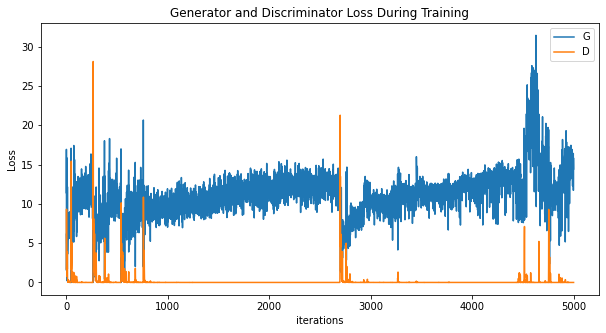

In [82]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

**Visualization of G’s progression**

Remember how we saved the generator’s output on the fixed_noise batch
after every epoch of training. Now, we can visualize the training
progression of G with an animation. Press the play button to start the
animation.




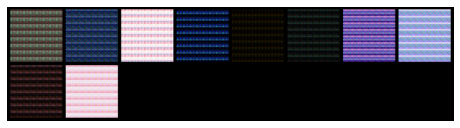

In [83]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

**Real Images vs. Fake Images**

Finally, lets take a look at some real images and fake images side by
side.




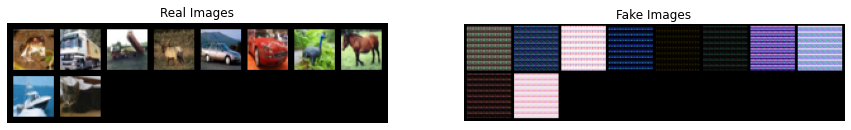

In [84]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

# Where to Go Next


We have reached the end of our journey, but there are several places you
could go from here. You could:

-  Train for longer to see how good the results get
-  Modify this model to take a different dataset and possibly change the
   size of the images and the model architecture
-  Check out some other cool GAN projects
   `here <https://github.com/nashory/gans-awesome-applications>`__
-  Create GANs that generate
   `music <https://deepmind.com/blog/wavenet-generative-model-raw-audio/>`__




# Additional Notes

In [85]:
noise = torch.randn(2, 3, 2,2, device=device)
noise2 = torch.randn(2, 6, device=device)
l = torch.matmul(noise, noise2)


# print(l.size())
# print(noise.size())

# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

noise = torch.randn(3, 2, 1,1, device=device)
layer = nn.Linear(1, 6)      
l = layer(noise)
# print(l.size())

# 아래에서 에러가 나는 이유는 matrix multiplication 작동을 몰라서 그렇다.
# 차원이 3개 이상인 경우 맨 마지막 두 차원을 제외한 앞의 차원들은 모두 배치 차원이 된다.
# 즉, 뒤에 2 차원들 끼리는 matrix multiplication이 되도록 차원을 맞춰야 한다.

noise = torch.randn(3, 2, 1,1, device=device)
layer = nn.Linear(2, 6)      
l = layer(noise)
# print(l.size())


RuntimeError: ignored

In [ ]:
H = W = 32
h = w = 4
nh = H // h
nw = W // w
Ys = torch.randn(1, nh*nw, D)
Ys = Ys.unsqueeze(1).repeat(1, 64, 1, 1)
Ys.shape

In [ ]:
H = W = 32
h = w = 4
nh = H // h
nw = W // w
B = 128

h_basis = torch.linspace(0, nh-1, nh).div(nh-1).mul(2).sub(1)
w_basis = torch.linspace(0, nw-1, nw).div(nw-1).mul(2).sub(1)
coords2d = torch.meshgrid(h_basis, w_basis)
# print(coords2d)

coords2d = torch.stack(coords2d, 0).reshape(2, nh*nw).t()
coords2d_patch_position = coords2d.unsqueeze(0).repeat(B, 1, 1)
# print(coords2d_patch_position.shape)

In [ ]:
coords_new = rearrange(coords2d, '(nh h nw w) D -> (nh nw) (h w) D', nh=nh, h=h, nw=nw, w=w, D=2)
# print(coords_new.unsqueeze(0).repeat(B, 1, 1, 1).shape)

coords_new = repeat(coords2d, '(nh h nw w) D -> B (nh nw) (h w) D', B=B, nh=nh, h=h, nw=nw, w=w, D=2).shape # nh h nw w 인지 어떻게 알까?
# print(coords_new)

이미지를 불러와서 아래와 같이 reshape 해보고, 이미지 그대로 복원되는지 보기.
 

3,64,64

4096, 3

3, 64, 64

In [ ]:
D = 256
L = 10 # num tokens
B = 4 # num batch
net = nn.Linear(D, D)

input = torch.randn(B, L, D)
input.bmm(input.permute(0, 2, 1)).shape

In [ ]:
class CustomNet(nn.Module):
  def __init__(self):
    super().__init__()

    self.features = nn.Sequential(
        nn.Linear(10, 20),
        nn.Conv2d(3, 3, 1, 1, 1),
        nn.ReLU()
    )
    self.features2 = nn.Sequential(
        nn.Linear(10, 20),
        nn.ReLU()
    )

    self.apply(self.__init_weight__)
  def forward(self, x):
    return None

  def __init_weight__(self, m):
    if isinstance(m, (nn.Linear,)):
      nn.utils.spectral_norm(m)

net = CustomNet()